# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 6: Logistic Regression and Bootstrapping

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Albert Wu, Nathaniel Burbank<br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

<center>**Download this notebook from the CS109 repo or here:**</center>
<center>**http://bit.ly/109_S6**</center>

In this section we will be covering logistic regression using a cancer dataset. The goal is to get you familiarized with the implementation of logistic regresison and bootstrapping through the use of a dataset we haven't seen. The exercises below will help you be able to answer parts of Homework 5.

Specifically, we will: 
    
    1. Load in and get a feel for the prostate cancer dataset, which is similar in structure to our homework.
    2. Fit a logistic regression model to only one predictor and understand how to interpret the results.
    3. Compare to a linear regression model and then fit the logistic regression model to the entire dataset.
    3. Take the results from the logistic regression model to create a bootstrap with confidence intervals.


For this section we will be using the following packages:

In [128]:
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 1000)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.api import add_constant

from statsmodels.regression.linear_model import RegressionResults
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
# Note --  Requires sklearn version .18 or higher  

from sklearn.metrics import r2_score
from collections import Counter
sns.set(style="ticks")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

assert(sys.version_info.major==3),print(sys.version)
# Python 3 or higher is required

## Warmup – back to the titanic dataset

In [129]:
import statsmodels.formula.api as sm
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [130]:
# Subset to only cols we want
titanic = titanic[['sex', 'age', 'class', 'survived']]

# Rename 'class' col to 'pclass' to avoid namespace issues
titanic.columns = ['sex', 'age', 'pclass', 'survived']

#Drop any row with NA values in any col in dataframe
titanic = titanic.dropna()

is_female = pd.get_dummies(titanic.sex)['female']
pclass_coded = pd.get_dummies(titanic.pclass)[['First','Second']]

titanic_c = pd.concat([is_female,pclass_coded,titanic[['age','survived']]],axis=1)
titanic_c.head()

,female,First,Second,age,survived
0,0,0,0,22.0,0
1,1,1,0,38.0,1
2,1,0,0,26.0,1
3,1,1,0,35.0,1
4,0,0,0,35.0,0


In [131]:
train, test =  train_test_split(titanic_c, test_size=.2, random_state=123)
model = sm.logit(formula="survived ~ female + First + Second + age", data=train)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.443915
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  571
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            4
Date:                Tue, 17 Oct 2017   Pseudo R-squ.:                  0.3441
Time:                        21:05:51   Log-Likelihood:                -253.48
converged:                       True   LL-Null:                       -386.45
                                        LLR p-value:                 2.391e-56
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3532      0.282     -4.801      0.000      -1.906      -0.801
female         2.6625      0.238     11.207      0.000       2.197       3.128
First          2.5966      0.314      8.276      0.000       1.982       3.212
Second         1.1384      0.279      4.080      0.000       0.591       1.685
age           -0.0360      0.009     -4.124      0.000      -0.053      -0.019
==============================================================================
"""

Note that all our predictors are significant here, and none of the confidence intervals include zero. 

### Interpreting logistic regression 

Being a first class passanger increases the *logit of the probability* of surviving by **X**, relative to being a third-class passanger. 

In [132]:
model.params.First

2.5966496929609466

The odds of First class passengers surviving are **X** times more likely than the odds of a third-class passenger surviving. 

In [133]:
np.exp(model.params.First)

13.418705856625333

Calculate the probability of each passenger in our training set surviving, without using model.predict 

Hint:
$$ p = \cfrac{e^\eta}{1+e^\eta} =  \cfrac{1}{1+e^{-\eta}}  $$

Where, $\eta = \alpha + \beta_1 X_1 + ... + \beta_n X_n$

In [134]:
x_train = titanic_c[['female','First','Second','age']]
eta = model.params.values[0] + np.sum(model.params.values[1:]*x_train,axis=1)
1/(1+np.exp(-eta))

0      0.104866
1      0.926865
2      0.592506
3      0.933848
4      0.068387
6      0.332193
7      0.193857
8      0.583796
9      0.874816
10     0.762313
11     0.860607
12     0.111811
13     0.059773
14     0.691219
15     0.615377
16     0.193857
18     0.548484
20     0.186437
21     0.191952
22     0.683492
23     0.558879
24     0.735279
25     0.485715
27     0.636506
30     0.451434
33     0.069914
34     0.558879
35     0.433695
37     0.108289
38     0.659709
39     0.691219
40     0.467777
41     0.814086
43     0.912117
44     0.651591
49     0.659709
50     0.167294
51     0.108289
52     0.895103
53     0.802955
54     0.250900
56     0.844557
57     0.084865
58     0.906179
59     0.148204
60     0.104866
61     0.926865
62     0.407414
63     0.182865
66     0.802955
67     0.115432
68     0.667734
69     0.092112
70     0.203354
71     0.675663
72     0.274895
73     0.092112
74     0.075588
75     0.095163
78     0.439138
79     0.557372
80     0.104866
81     0

In [135]:
model.predict(x_train)

0      0.104866
1      0.926865
2      0.592506
3      0.933848
4      0.068387
6      0.332193
7      0.193857
8      0.583796
9      0.874816
10     0.762313
11     0.860607
12     0.111811
13     0.059773
14     0.691219
15     0.615377
16     0.193857
18     0.548484
20     0.186437
21     0.191952
22     0.683492
23     0.558879
24     0.735279
25     0.485715
27     0.636506
30     0.451434
33     0.069914
34     0.558879
35     0.433695
37     0.108289
38     0.659709
39     0.691219
40     0.467777
41     0.814086
43     0.912117
44     0.651591
49     0.659709
50     0.167294
51     0.108289
52     0.895103
53     0.802955
54     0.250900
56     0.844557
57     0.084865
58     0.906179
59     0.148204
60     0.104866
61     0.926865
62     0.407414
63     0.182865
66     0.802955
67     0.115432
68     0.667734
69     0.092112
70     0.203354
71     0.675663
72     0.274895
73     0.092112
74     0.075588
75     0.095163
78     0.439138
79     0.557372
80     0.104866
81     0

## Part (1): Load in our data and conduct basic EDA


We will first load in our dataset below and look at the first few rows. Then, we use the describe function to get a sense of the data. **NOTE: A friendly reminder, this data is different from that of the homework. Please take care to make sure you do not accidentally use this data for the homework!**

In [136]:
df = pd.read_csv('https://github.com/albertw1/data/raw/master/section_6_cancer_data.csv')
df.head()

,Y,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,Gene 11,Gene 12,Gene 13,Gene 14,Gene 15,Gene 16,Gene 17,Gene 18,Gene 19,Gene 20,Gene 21,Gene 22,Gene 23,Gene 24,Gene 25,Gene 26,Gene 27,Gene 28,Gene 29,Gene 30,Gene 31,Gene 32,Gene 33,Gene 34,Gene 35,Gene 36,Gene 37,Gene 38,Gene 39,Gene 40,Gene 41,Gene 42,Gene 43,Gene 44,Gene 45,Gene 46,Gene 47,Gene 48,Gene 49,Gene 50,Gene 51,Gene 52,Gene 53,Gene 54,Gene 55,Gene 56,Gene 57,Gene 58,Gene 59,Gene 60,Gene 61,Gene 62,Gene 63,Gene 64,Gene 65,Gene 66,Gene 67,Gene 68,Gene 69,Gene 70,Gene 71,Gene 72,Gene 73,Gene 74,Gene 75,Gene 76,Gene 77,Gene 78,Gene 79,Gene 80,Gene 81,Gene 82,Gene 83,Gene 84,Gene 85,Gene 86,Gene 87,Gene 88,Gene 89,Gene 90,Gene 91,Gene 92,Gene 93,Gene 94,Gene 95,Gene 96,Gene 97,Gene 98,Gene 99,Gene 100,Gene 101,Gene 102,Gene 103,Gene 104,Gene 105,Gene 106,Gene 107,Gene 108,Gene 109,Gene 110,Gene 111,Gene 112,Gene 113,Gene 114,Gene 115,Gene 116,Gene 117,Gene 118,Gene 119,Gene 120,Gene 121,Gene 122,Gene 123,Gene 124,Gene 125,Gene 126,Gene 127,Gene 128,Gene 129,Gene 130,Gene 131,Gene 132,Gene 133,Gene 134,Gene 135,Gene 136,Gene 137,Gene 138,Gene 139,Gene 140,Gene 141,Gene 142,Gene 143,Gene 144,Gene 145,Gene 146,Gene 147,Gene 148,Gene 149,Gene 150,Gene 151,Gene 152,Gene 153,Gene 154,Gene 155,Gene 156,Gene 157,Gene 158,Gene 159,Gene 160,Gene 161,Gene 162,Gene 163,Gene 164,Gene 165,Gene 166,Gene 167,Gene 168,Gene 169,Gene 170,Gene 171,Gene 172,Gene 173,Gene 174,Gene 175,Gene 176,Gene 177,Gene 178,Gene 179,Gene 180,Gene 181,Gene 182,Gene 183,Gene 184,Gene 185,Gene 186,Gene 187,Gene 188,Gene 189,Gene 190,Gene 191,Gene 192,Gene 193,Gene 194,Gene 195,Gene 196,Gene 197,Gene 198,Gene 199,Gene 200,Gene 201,Gene 202,Gene 203,Gene 204,Gene 205,Gene 206,Gene 207,Gene 208,Gene 209,Gene 210,Gene 211,Gene 212,Gene 213,Gene 214,Gene 215,Gene 216,Gene 217,Gene 218,Gene 219,Gene 220,Gene 221,Gene 222,Gene 223,Gene 224,Gene 225,Gene 226,Gene 227,Gene 228,Gene 229,Gene 230,Gene 231,Gene 232,Gene 233,Gene 234,Gene 235,Gene 236,Gene 237,Gene 238,Gene 239,Gene 240,Gene 241,Gene 242,Gene 243,Gene 244,Gene 245,Gene 246,Gene 247,Gene 248,Gene 249,Gene 250,Gene 251,Gene 252,Gene 253,Gene 254,Gene 255,Gene 256,Gene 257,Gene 258,Gene 259,Gene 260,Gene 261,Gene 262,Gene 263,Gene 264,Gene 265,Gene 266,Gene 267,Gene 268,Gene 269,Gene 270,Gene 271,Gene 272,Gene 273,Gene 274,Gene 275,Gene 276,Gene 277,Gene 278,Gene 279,Gene 280,Gene 281,Gene 282,Gene 283,Gene 284,Gene 285,Gene 286,Gene 287,Gene 288,Gene 289,Gene 290,Gene 291,Gene 292,Gene 293,Gene 294,Gene 295,Gene 296,Gene 297,Gene 298,Gene 299,Gene 300,Gene 301,Gene 302,Gene 303,Gene 304,Gene 305,Gene 306,Gene 307,Gene 308,Gene 309,Gene 310,Gene 311,Gene 312,Gene 313,Gene 314,Gene 315,Gene 316,Gene 317,Gene 318,Gene 319,Gene 320,Gene 321,Gene 322,Gene 323,Gene 324,Gene 325,Gene 326,Gene 327,Gene 328,Gene 329,Gene 330,Gene 331,Gene 332,Gene 333,Gene 334,Gene 335,Gene 336,Gene 337,Gene 338,Gene 339,Gene 340,Gene 341,Gene 342,Gene 343,Gene 344,Gene 345,Gene 346,Gene 347,Gene 348,Gene 349,Gene 350,Gene 351,Gene 352,Gene 353,Gene 354,Gene 355,Gene 356,Gene 357,Gene 358,Gene 359,Gene 360,Gene 361,Gene 362,Gene 363,Gene 364,Gene 365,Gene 366,Gene 367,Gene 368,Gene 369,Gene 370,Gene 371,Gene 372,Gene 373,Gene 374,Gene 375,Gene 376,Gene 377,Gene 378,Gene 379,Gene 380,Gene 381,Gene 382,Gene 383,Gene 384,Gene 385,Gene 386,Gene 387,Gene 388,Gene 389,Gene 390,Gene 391,Gene 392,Gene 393,Gene 394,Gene 395,Gene 396,Gene 397,Gene 398,Gene 399,Gene 400,Gene 401,Gene 402,Gene 403,Gene 404,Gene 405,Gene 406,Gene 407,Gene 408,Gene 409,Gene 410,Gene 411,Gene 412,Gene 413,Gene 414,Gene 415,Gene 416,Gene 417,Gene 418,Gene 419,Gene 420,Gene 421,Gene 422,Gene 423,Gene 424,Gene 425,Gene 426,Gene 427,Gene 428,Gene 429,Gene 430,Gene 431,Gene 432,Gene 433,Gene 434,Gene 435,Gene 436,Gene 437,Gene 438,Gene 439,Gene 440,Gene 441,Gene 442,Gene 443,Gene 444,Gene 445,Gene 446,Gene 447,Gene 448,Gene 449,Gene 450,Gene 451,Gene 452,Gene 453,Gene 454,Gene 455,Gene 456,G

In [137]:
df.describe()

Y      Gene 1      Gene 2      Gene 3      Gene 4      Gene 5      Gene 6      Gene 7      Gene 8      Gene 9     Gene 10     Gene 11     Gene 12     Gene 13     Gene 14     Gene 15     Gene 16     Gene 17     Gene 18     Gene 19     Gene 20     Gene 21     Gene 22     Gene 23     Gene 24     Gene 25     Gene 26     Gene 27     Gene 28     Gene 29     Gene 30     Gene 31     Gene 32     Gene 33     Gene 34     Gene 35     Gene 36     Gene 37     Gene 38     Gene 39     Gene 40     Gene 41     Gene 42     Gene 43     Gene 44     Gene 45     Gene 46     Gene 47     Gene 48     Gene 49     Gene 50     Gene 51     Gene 52     Gene 53     Gene 54     Gene 55     Gene 56     Gene 57     Gene 58     Gene 59     Gene 60     Gene 61     Gene 62     Gene 63     Gene 64     Gene 65     Gene 66     Gene 67     Gene 68     Gene 69     Gene 70     Gene 71     Gene 72     Gene 73     Gene 74     Gene 75     Gene 76     Gene 77     Gene 78     Gene 79     Gene 80     Gene 81  \
count  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000  102.000000   
mean     0.509804   -0.623086   -0.665809   -0.586693   -0.895592   -0.438002   -0.152997   -0.593764    4.361345   -0.553667   -0.951837    0.210988   -0.655313   -0.942147    1.056787    1.048407    2.420894    1.385449    1.984182    3.279895   -0.804082   -0.663843   -0.547087    0.982289    0.420177    0.589138   -0.654416   -0.763602   -0.177263   -0.354601   -0.733137    1.019639   -0.853698   -0.387593   -0.723554    0.333692   -0.870300    2.302401   -0.923628   -0.615913   -0.573766   -0.665838   -0.520763   -0.880360    0.206195   -0.512913   -0.927772   -0.818706   -0.693632   -0.077625   -0.674515   -0.792538   -0.596294   -0.943320    2.282409    0.475842   -0.598812    1.027012   -0.725107    0.342511   -0.816244   -0.278585   -0.498915   -0.177066   -0.528816   -0.262572   -0.948803   -0.852756   -0.833931   -0.218727   -0.653240    1.429048   -0.771873   -0.073120    0.287660    0.001412   -0.551145   -0.686902   -0.494723   -0.368184    0.538564    0.488985   
std      0.502373    0.409905    0.378207    0.497839    0.190989    0.597182    0.789601    0.414790    0.410420    0.399223    0.181319    0.606445    0.469975    0.243418    0.730810    1.528193    0.703898    0.712412    1.423613    0.860988    0.314300    0.455784    0.569803    0.607126    0.735268    0.669660    0.401457    0.292917    0.518869    0.560968    0.427445    0.629158    0.282037    0.527495    0.362698    0.837500    0.241137    1.421855    0.202965    0.667866    0.430846    0.352903    0.511037    0.225416    0.577369    0.537635    0.211668    0.339570    0.372069    0.664546    0.484781    0.311698    0.368384    0.191362    1.739226    0.716093    0.408567    0.581369    0.322546    1.304549    0.285212    0.568969    0.569240    0.597381    0.470440    0.765572    0.203211    0.264404    0.293816    0.563874    0.391422    0.642131    0.350769    0.536137    0.673359    0.957940    0.498118    0.460433    0.428367    0.638959    0.628258    0.855911   
min      0.000000   -1.130098   -1.206937   

As we can see, `Y` here is the response variable (`Y` = 1 is cancer and `Y` = 0 is no cancer) and the 6033 predictor variables are gene expressions. The meaning of each column has no easily interpretable meaning. The way to think about it is that the bigger the value is for a gene, the more likely that gene could lead to someone having cancer. Each row represents a person.

Now, let's split this dataset up into a testing and training set using a 50-50 split. 

In [138]:
np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.5
data_train_ns = df[msk] # ns for non-standarized data, we will standardize it right after this
data_test_ns = df[~msk]
data_train_ns.head()

,Y,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,Gene 11,Gene 12,Gene 13,Gene 14,Gene 15,Gene 16,Gene 17,Gene 18,Gene 19,Gene 20,Gene 21,Gene 22,Gene 23,Gene 24,Gene 25,Gene 26,Gene 27,Gene 28,Gene 29,Gene 30,Gene 31,Gene 32,Gene 33,Gene 34,Gene 35,Gene 36,Gene 37,Gene 38,Gene 39,Gene 40,Gene 41,Gene 42,Gene 43,Gene 44,Gene 45,Gene 46,Gene 47,Gene 48,Gene 49,Gene 50,Gene 51,Gene 52,Gene 53,Gene 54,Gene 55,Gene 56,Gene 57,Gene 58,Gene 59,Gene 60,Gene 61,Gene 62,Gene 63,Gene 64,Gene 65,Gene 66,Gene 67,Gene 68,Gene 69,Gene 70,Gene 71,Gene 72,Gene 73,Gene 74,Gene 75,Gene 76,Gene 77,Gene 78,Gene 79,Gene 80,Gene 81,Gene 82,Gene 83,Gene 84,Gene 85,Gene 86,Gene 87,Gene 88,Gene 89,Gene 90,Gene 91,Gene 92,Gene 93,Gene 94,Gene 95,Gene 96,Gene 97,Gene 98,Gene 99,Gene 100,Gene 101,Gene 102,Gene 103,Gene 104,Gene 105,Gene 106,Gene 107,Gene 108,Gene 109,Gene 110,Gene 111,Gene 112,Gene 113,Gene 114,Gene 115,Gene 116,Gene 117,Gene 118,Gene 119,Gene 120,Gene 121,Gene 122,Gene 123,Gene 124,Gene 125,Gene 126,Gene 127,Gene 128,Gene 129,Gene 130,Gene 131,Gene 132,Gene 133,Gene 134,Gene 135,Gene 136,Gene 137,Gene 138,Gene 139,Gene 140,Gene 141,Gene 142,Gene 143,Gene 144,Gene 145,Gene 146,Gene 147,Gene 148,Gene 149,Gene 150,Gene 151,Gene 152,Gene 153,Gene 154,Gene 155,Gene 156,Gene 157,Gene 158,Gene 159,Gene 160,Gene 161,Gene 162,Gene 163,Gene 164,Gene 165,Gene 166,Gene 167,Gene 168,Gene 169,Gene 170,Gene 171,Gene 172,Gene 173,Gene 174,Gene 175,Gene 176,Gene 177,Gene 178,Gene 179,Gene 180,Gene 181,Gene 182,Gene 183,Gene 184,Gene 185,Gene 186,Gene 187,Gene 188,Gene 189,Gene 190,Gene 191,Gene 192,Gene 193,Gene 194,Gene 195,Gene 196,Gene 197,Gene 198,Gene 199,Gene 200,Gene 201,Gene 202,Gene 203,Gene 204,Gene 205,Gene 206,Gene 207,Gene 208,Gene 209,Gene 210,Gene 211,Gene 212,Gene 213,Gene 214,Gene 215,Gene 216,Gene 217,Gene 218,Gene 219,Gene 220,Gene 221,Gene 222,Gene 223,Gene 224,Gene 225,Gene 226,Gene 227,Gene 228,Gene 229,Gene 230,Gene 231,Gene 232,Gene 233,Gene 234,Gene 235,Gene 236,Gene 237,Gene 238,Gene 239,Gene 240,Gene 241,Gene 242,Gene 243,Gene 244,Gene 245,Gene 246,Gene 247,Gene 248,Gene 249,Gene 250,Gene 251,Gene 252,Gene 253,Gene 254,Gene 255,Gene 256,Gene 257,Gene 258,Gene 259,Gene 260,Gene 261,Gene 262,Gene 263,Gene 264,Gene 265,Gene 266,Gene 267,Gene 268,Gene 269,Gene 270,Gene 271,Gene 272,Gene 273,Gene 274,Gene 275,Gene 276,Gene 277,Gene 278,Gene 279,Gene 280,Gene 281,Gene 282,Gene 283,Gene 284,Gene 285,Gene 286,Gene 287,Gene 288,Gene 289,Gene 290,Gene 291,Gene 292,Gene 293,Gene 294,Gene 295,Gene 296,Gene 297,Gene 298,Gene 299,Gene 300,Gene 301,Gene 302,Gene 303,Gene 304,Gene 305,Gene 306,Gene 307,Gene 308,Gene 309,Gene 310,Gene 311,Gene 312,Gene 313,Gene 314,Gene 315,Gene 316,Gene 317,Gene 318,Gene 319,Gene 320,Gene 321,Gene 322,Gene 323,Gene 324,Gene 325,Gene 326,Gene 327,Gene 328,Gene 329,Gene 330,Gene 331,Gene 332,Gene 333,Gene 334,Gene 335,Gene 336,Gene 337,Gene 338,Gene 339,Gene 340,Gene 341,Gene 342,Gene 343,Gene 344,Gene 345,Gene 346,Gene 347,Gene 348,Gene 349,Gene 350,Gene 351,Gene 352,Gene 353,Gene 354,Gene 355,Gene 356,Gene 357,Gene 358,Gene 359,Gene 360,Gene 361,Gene 362,Gene 363,Gene 364,Gene 365,Gene 366,Gene 367,Gene 368,Gene 369,Gene 370,Gene 371,Gene 372,Gene 373,Gene 374,Gene 375,Gene 376,Gene 377,Gene 378,Gene 379,Gene 380,Gene 381,Gene 382,Gene 383,Gene 384,Gene 385,Gene 386,Gene 387,Gene 388,Gene 389,Gene 390,Gene 391,Gene 392,Gene 393,Gene 394,Gene 395,Gene 396,Gene 397,Gene 398,Gene 399,Gene 400,Gene 401,Gene 402,Gene 403,Gene 404,Gene 405,Gene 406,Gene 407,Gene 408,Gene 409,Gene 410,Gene 411,Gene 412,Gene 413,Gene 414,Gene 415,Gene 416,Gene 417,Gene 418,Gene 419,Gene 420,Gene 421,Gene 422,Gene 423,Gene 424,Gene 425,Gene 426,Gene 427,Gene 428,Gene 429,Gene 430,Gene 431,Gene 432,Gene 433,Gene 434,Gene 435,Gene 436,Gene 437,Gene 438,Gene 439,Gene 440,Gene 441,Gene 442,Gene 443,Gene 444,Gene 445,Gene 446,Gene 447,Gene 448,Gene 449,Gene 450,Gene 451,Gene 452,Gene 453,Gene 454,Gene 455,Gene 456,G

Now let us standarize our data to be between 0 and 1. 

In [139]:
# Your code goes here
data_train = (data_train_ns - data_train_ns.min(axis=0))/(data_train_ns.max(axis=0) - data_train_ns.min(axis=0))
data_test = (data_test_ns - data_train_ns.min(axis=0))/(data_train_ns.max(axis=0) - data_train_ns.min(axis=0))

data_train['Y']=data_train_ns['Y']
data_test['Y']=data_test_ns['Y']
data_train.describe()

Y     Gene 1     Gene 2     Gene 3     Gene 4     Gene 5     Gene 6     Gene 7     Gene 8     Gene 9    Gene 10    Gene 11    Gene 12    Gene 13    Gene 14    Gene 15    Gene 16    Gene 17    Gene 18    Gene 19    Gene 20    Gene 21    Gene 22    Gene 23    Gene 24    Gene 25    Gene 26    Gene 27    Gene 28    Gene 29    Gene 30    Gene 31    Gene 32    Gene 33    Gene 34    Gene 35    Gene 36    Gene 37    Gene 38    Gene 39    Gene 40    Gene 41    Gene 42    Gene 43    Gene 44    Gene 45    Gene 46    Gene 47    Gene 48    Gene 49    Gene 50    Gene 51    Gene 52    Gene 53    Gene 54    Gene 55    Gene 56    Gene 57    Gene 58    Gene 59    Gene 60    Gene 61    Gene 62    Gene 63    Gene 64    Gene 65    Gene 66    Gene 67    Gene 68    Gene 69    Gene 70    Gene 71    Gene 72    Gene 73    Gene 74    Gene 75    Gene 76    Gene 77    Gene 78    Gene 79    Gene 80    Gene 81    Gene 82    Gene 83    Gene 84    Gene 85    Gene 86    Gene 87    Gene 88    Gene 89  \
count  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000   
mean    0.555556   0.383577   0.320030   0.378820   0.318071   0.354756   0.396755   0.313066   0.478397   0.412885   0.478030   0.494924   0.335327   0.139823   0.479709   0.561239   0.617575   0.422122   0.622796   0.639505   0.302034   0.279714   0.270741   0.650406   0.498088   0.571854   0.271302   0.295273   0.448398   0.325227   0.248734   0.614359   0.257844   0.328624   0.274973   0.486901   0.254152   0.716429   0.409496   0.230406   0.377514   0.325719   0.349900   0.312920   0.517692   0.324438   0.314912   0.270547   0.317832   0.416715   0.287293   0.351266   0.296703   0.478030   0.667465   0.569652   0.362456   0.535833   0.323748   0.420864   0.336966   0.387970   0.330736   0.416420   0.268304   0.356917   0.478030   0.253282   0.253492   0.356001   0.387557   0.569766   0.272314   0.440194   0.508219   0.425305   0.227521   0.273551   0.340763   0.358209   0.577413   0.491663   0.470968   0.150264   0.322824   0.324471   0.318804   0.610798   0.478030   0.321037   
std     0.502519   0.299458   0.274361   0.295306   0.194051   0.283082   0.334383   0.258170   0.216552   0.280054   0.279078   0.237255   0.283082   0.153812   0.303240   0.379876   0.307605   0.301777   0.302004   0.264247   0.233362   0.255062   0.222415   0.256995   0.265332   0.272165   0.281467   0.228966   0.314848   0.314212   0.224392   0.248219   0.218887   0.325583   0.222870   0.356398   0.198773   0.303473   0.236268   0.256038   0.271662   0.214099   0.296967   0.217155   0.287275   0.271992   0.201110   0.224772   0.282229   0.324382   0.253848   0.259121   0.290691   0.279078   0.351935   0.309640   0.241004   0.277427   0.275182   0.350230   0.242202   0.337550   0.296291   0.348442   0.277196   0.290984   0.279078   0.200526   0.211508   0.308134   0.254170   0.251563   0.205377   0.288597   0.303104   0.342975   0.253842   0.228807   0.223585   0.273457   0.266921   0.327048   0.255894   0.160846   0.311259   0.264103   0.222751   0.302627   0.279078   0.246397   
min     0.000000   

Now to let us subset and create convenient formats for parts in train and test.

In [140]:
X_train = data_train.loc[:, data_train.columns != 'Y'] #Your code goes here
X_test  = data_test.loc[:, data_test.columns != 'Y']
X_train_np = X_train.values # This is to create a numpy array version of the training and testing set.
X_test_np  = X_test.values
y_train = data_train['Y'].values
y_test = data_test['Y'].values

## Part (2): Using one single predictor to fit a Linear Regression Model


Let's use one single predictor variable, `Gene 10` and fit a linear regression model to it. 

In [141]:
import statsmodels.api as sm
X_train_gene_10 = sm.add_constant(X_train["Gene 10"])
X_test_gene_10 = sm.add_constant(X_test["Gene 10"])

ols = OLS(endog=y_train, exog=X_train_gene_10).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     8.306
Date:                Tue, 17 Oct 2017   Prob (F-statistic):            0.00614
Time:                        21:06:20   Log-Likelihood:                -28.407
No. Observations:                  45   AIC:                             60.81
Df Residuals:                      43   BIC:                             64.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2092      0.139      1.508      0.139      -0.071       0.489
Gene 10        0.7245      0.251      2.882      0.006       0.218       1.231
==============================================================================
Omnibus:                       17.192   Durbin-Watson:                   0.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.528
Skew:                          -0.160   Prob(JB):                        0.171
Kurtosis:                       1.666   Cond. No.                         4.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Let’s plot our model… 

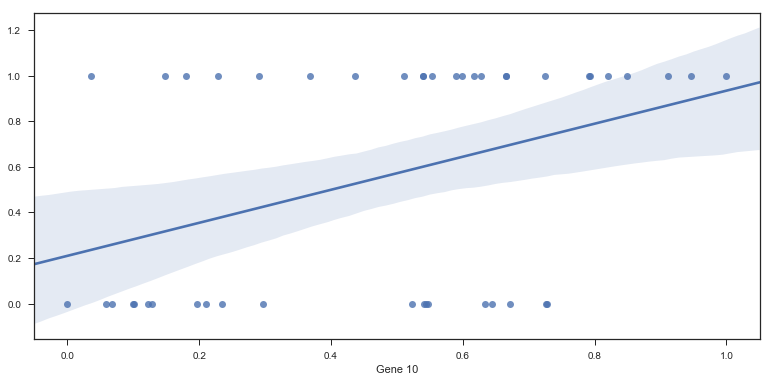

In [142]:
sns.regplot(x=X_train["Gene 10"], y=y_train)

In [143]:
y_hat_train = ols.predict(X_train_gene_10)
y_hat_test = ols.predict(X_test_gene_10)
print(y_hat_test)

1     0.729194
2     0.282786
3     0.328790
4     0.328811
6     0.249891
7     0.374069
8     0.293342
10    0.559819
11    0.352935
17    0.248222
19    0.830855
20    0.559189
22    0.437803
23    0.406408
24    0.672286
25    0.573603
26    0.560174
29    0.709629
30    0.612260
31    0.637726
32    0.676620
34    0.600042
36    0.423485
37    0.598601
38    0.286982
41    2.277758
42    0.651512
43    0.563009
45    0.777572
49    0.770148
50    0.657317
51    0.721028
53    0.347195
54    0.737462
56    0.416964
59    0.394674
64    0.387458
65    0.427232
67    0.249192
70    0.592169
71    0.588983
73    0.498894
74    0.658137
75    0.640102
76    0.633631
77    0.725309
78    0.706165
79    0.445048
80    0.250237
81    0.737036
83    0.565642
87    0.770051
88    0.766984
91    0.209071
95    0.757744
97    0.762108
98    0.781162
dtype: float64


Do you see anything "wrong" above with the predictions we made for the test set using the linear regression model? Hint: look at entry number 41.

Notice it is possible for us to convert the above values into a binary classification by the following code.

In [144]:
y_hat_train_0_1 = y_hat_train >.5
y_hat_test_0_1 = y_hat_test >.5

print("Training Set Accuracy for Linear Regression: ", accuracy_score(y_train, y_hat_train_0_1))
print("Test Set Accuracy for Linear Regression: ", accuracy_score(y_test, y_hat_test_0_1))

Training Set Accuracy for Linear Regression:  0.666666666667
Test Set Accuracy for Linear Regression:  0.508771929825


## Part (3): Using one single predictor to fit a Logistic Regression Model instead


Now we can instead fit a logistic regression model onto our data and see how things change.

In [145]:
logistic_mod = LogisticRegression(C=1000000, fit_intercept=True) #The C value here is a way to prevent regularization
X_train_mul_wcons = sm.add_constant(X_train["Gene 10"])
X_test_mul_wcons = sm.add_constant(X_test["Gene 10"])
logistic_mod.fit(X_train_mul_wcons, y_train)

y_hat_train_logistic_mod = logistic_mod.predict(X_train_mul_wcons)
y_hat_test_logistic_mod = logistic_mod.predict(X_test_mul_wcons)

print("Training Accuracy for Logistic Regression: ", accuracy_score(y_train, y_hat_train_logistic_mod))
print("Test Accuracy for Logistic Regression: ", accuracy_score(y_test, y_hat_test_logistic_mod))

Training Accuracy for Logistic Regression:  0.666666666667
Test Accuracy for Logistic Regression:  0.526315789474


As we see, the training accuracy is basically the same, but the test accuracy with logsitic regression is better due to being able to better account for the cases where the response variable is very large and very small for `Gene 10`. The takeaway message here is that logistic regresison will outperform a model when your `Y` values tend to be very extreme.

## Part (4): Using all predictor variables in a logistic regression

In [146]:
logistic_mod_all = LogisticRegression(C=100000, fit_intercept=True)
X_train_mul_wcons = sm.add_constant(X_train)
X_test_mul_wcons = sm.add_constant(X_test)

logistic_mod_all.fit(X_train_mul_wcons, y_train)
y_hat_train_logistic_mod_all = logistic_mod_all.predict(X_train_mul_wcons)
y_hat_test_logistic_mod_all = logistic_mod_all.predict(X_test_mul_wcons)
print("Training accuracy for Logistic Regression: ", accuracy_score(y_train, y_hat_train_logistic_mod_all))
print("Test accuracy for Logistic Regression: ", accuracy_score(y_test, y_hat_test_logistic_mod_all))

Training accuracy for Logistic Regression:  1.0
Test accuracy for Logistic Regression:  0.824561403509


In [147]:
predicted = np.round(y_hat_test_logistic_mod_all)
expected = y_test
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.86      0.80      0.83        30
          1       0.79      0.85      0.82        27

avg / total       0.83      0.82      0.82        57



In [148]:
pd.crosstab(expected,predicted,margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,All
Actual,,,
0,24,6,30
1,4,23,27
All,28,29,57


Using this matrix, we can see that of the people who actually **did not** have cancer, 6 were said to have cancer (false positive), while of the people who acutally **did** have cancer, 4 were mistakenly said to not have it (false negative). In biomedical applications, it usually is the case that false negatives tend to have greater consequences. For example, a patient would rather be told they mistakenly had cancer, which might lead to more testing.

## Part (4): Incorporating Bootstrapping in a Logistic Regression Model

The main idea behind bootstrapping is to resample our data many times. For EACH time that we resample our data, we will fit the Logistic Regression model. Then for EACH resampling, we can find an associated confidence interval. Notice how we have many more predictors than observations. Intuitively, that creates a problem in that we do not have enough observations to "represent" each predictor varaible. Hence, the resampling gives us a way to approximate our standard errors. 

The goal here is to find confidence intervals for our logistic regression model using ALL the predictors. You may ask, why don't we just fit a logistic regression, then look at the reported standard errors and confidence intervals? The answer is that with more predictors than observations, the reported confidence intervals will look like NaN. 

### A simple example of why we need a bootstrap when the predictors are greater than our observations:

As an example, we can fit a regularized logistic regression model on ONLY the first 90 genes. The 90 was a random number I chose to be greater than the observations (we could have done 100, 3000, etc). We only did the first 90 as it would take forever to do all 6033 genes. The reason we used the regularization fit was to get the logistic module to report at least some of the NaN's. Notice how many NaN's there are for the confidence intervals reported below, even with something like regularization!

In [152]:
import statsmodels.discrete.discrete_model as dm
model1 = dm.Logit(y_train, X_train_mul_wcons.iloc[:,0:91]).fit_regularized()
print(model1.summary())


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.76542346600213e-11
            Iterations: 47
            Function evaluations: 48
            Gradient evaluations: 47
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:                          Logit   Df Residuals:                      -46
Method:                           MLE   Df Model:                           90
Date:                Tue, 17 Oct 2017   Pseudo R-squ.:                   1.000
Time:                        21:09:13   Log-Likelihood:            -3.9444e-09
converged:                       True   LL-Null:                       -30.913
                                        LLR p-value:                    0.9898
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

### The code below helps us conduct a boostrap analysis and be able to obtain confidence interval estimates for each coefficient value!

The above example shows us we need a method to be able to estimate our confidence intervals as it clearly is lacking at only 90 genes. The following code helps us conduct a bootstrap analysis and estimate just how many of our coefficients are significant.

In [153]:
B = 100 # Number of iterations

boot_coefs = np.zeros((X_train.shape[1]+1,B)) # Create empty storage array for later use

for i in range(B):
    # Sampling WITH replacement the indices of a resampled dataset
    sample_index = np.random.choice(range(len(y_train)), size=len(y_train), replace=True)
    X_train_samples = X_train_mul_wcons.values[sample_index]
    y_train_samples = y_train[sample_index]
    
    logistic_mod_boot = LogisticRegression(C=100000, fit_intercept=True)
    logistic_mod_boot.fit(X_train_samples, y_train_samples)
    boot_coefs[:,i] = logistic_mod_boot.coef_

boot_coefs.shape

(6034, 100)

If we wanted to find the 95 percent confidence interval, we can use the `np.percentile` function to find the datapoint that corresponds to the upper and lower bounds. As an example, we have the upper datapoint for the 95% confidence interval. (Why is it 97.5? Think of an interval from 0 to 100, and you want to shade in 95% of that interval, while keeping the length to the left and right of the shading the same. Where does the shading end and begin?)

In [154]:
ci_upper = np.percentile(boot_coefs, 97.5, axis=1)
ci_lower = np.percentile(boot_coefs, 2.5, axis=1)

In [155]:
# ct significant predictors
sig_b_ct = 0

# if ci contains 0, then insignificant
for i in range(len(ci_upper)):
    if ci_upper[i]<0 or ci_lower[i]>0:
        sig_b_ct += 1

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, X_train_np.shape[1]))

Significant coefficents at 5pct level = 1909 / 6033
